#Text Classification (CNN)

**import libraries**

In [1]:
import pandas as pd
import numpy as np
import time
import re


import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation,Input,MaxPooling1D,Embedding,Flatten
from keras.layers import Concatenate,Dropout,Convolution1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Using TensorFlow backend.


**Clean texts**

In [2]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

**Load data (instances)**

In [9]:
def load_data():
    pos_examples = list(open('./data/rt-polarity.pos', encoding='latin-1').readlines())
    pos_examples = [s.strip() for s in pos_examples]
    pos_labels = [1 for _ in pos_examples]
    print('Positive examples -> %s.' % len(pos_examples))
    
    neg_examples = list(open('./data/rt-polarity.neg', encoding='latin-1').readlines())
    neg_examples = [s.strip() for s in neg_examples]
    neg_labels = [0 for _ in neg_examples]
    print('Negative examples -> %s.' % len(neg_examples))
    
    
    x_text = np.concatenate([pos_examples,neg_examples],0)
    x_text = [clean_str(sent) for sent in x_text]
    y = np.concatenate([pos_labels, neg_labels], 0)
    shuffle_indices = np.random.permutation(np.arange(len(x_text)))
    x_text = np.array(x_text)[shuffle_indices]
    y = y[shuffle_indices]
    print('Total examples -> %s.' % len(x_text))
    return x_text, y
        

**Models**

In [4]:
#https://keras.io/api/

def create_model(vocab_size, embedding_dim, num_filters,filter_size,max_sequence_length):
    model_input = Input(shape=(max_sequence_length,))
    embed_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length, name="embedding")(model_input)
    # Convolutional block
    conv_blocks = []
    for index,sz in enumerate(filter_size):
        conv = Convolution1D(filters=num_filters,
                             kernel_size=sz,
                             padding="valid",
                             activation="relu",
                             strides=1,
                             name='conv-{}'.format(index))(embed_layer)
        conv = MaxPooling1D(pool_size=2)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    concat = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

    dense_1 = Dense(50, activation="relu")(concat)
    model_output = Dense(1, activation="sigmoid")(dense_1)
    model = Model(model_input, model_output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

**Load data**

In [10]:
texts,labels = load_data()
max_sequence_length = np.max([len(txt) for txt in texts])
max_sequence_length

Positive examples -> 5331.
Negative examples -> 5331.
Total examples -> 10662.


266

**Transform input**

In [11]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
x = pad_sequences(sequences, maxlen=max_sequence_length)

x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42)


Found 18758 unique tokens.


**Create model**

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 266)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 266, 300)     5627700     input_2[0][0]                    
__________________________________________________________________________________________________
conv-0 (Conv1D)                 (None, 264, 128)     115328      embedding[0][0]                  
__________________________________________________________________________________________________
conv-1 (Conv1D)                 (None, 263, 128)     153728      embedding[0][0]                  
____________________________________________________________________________________________

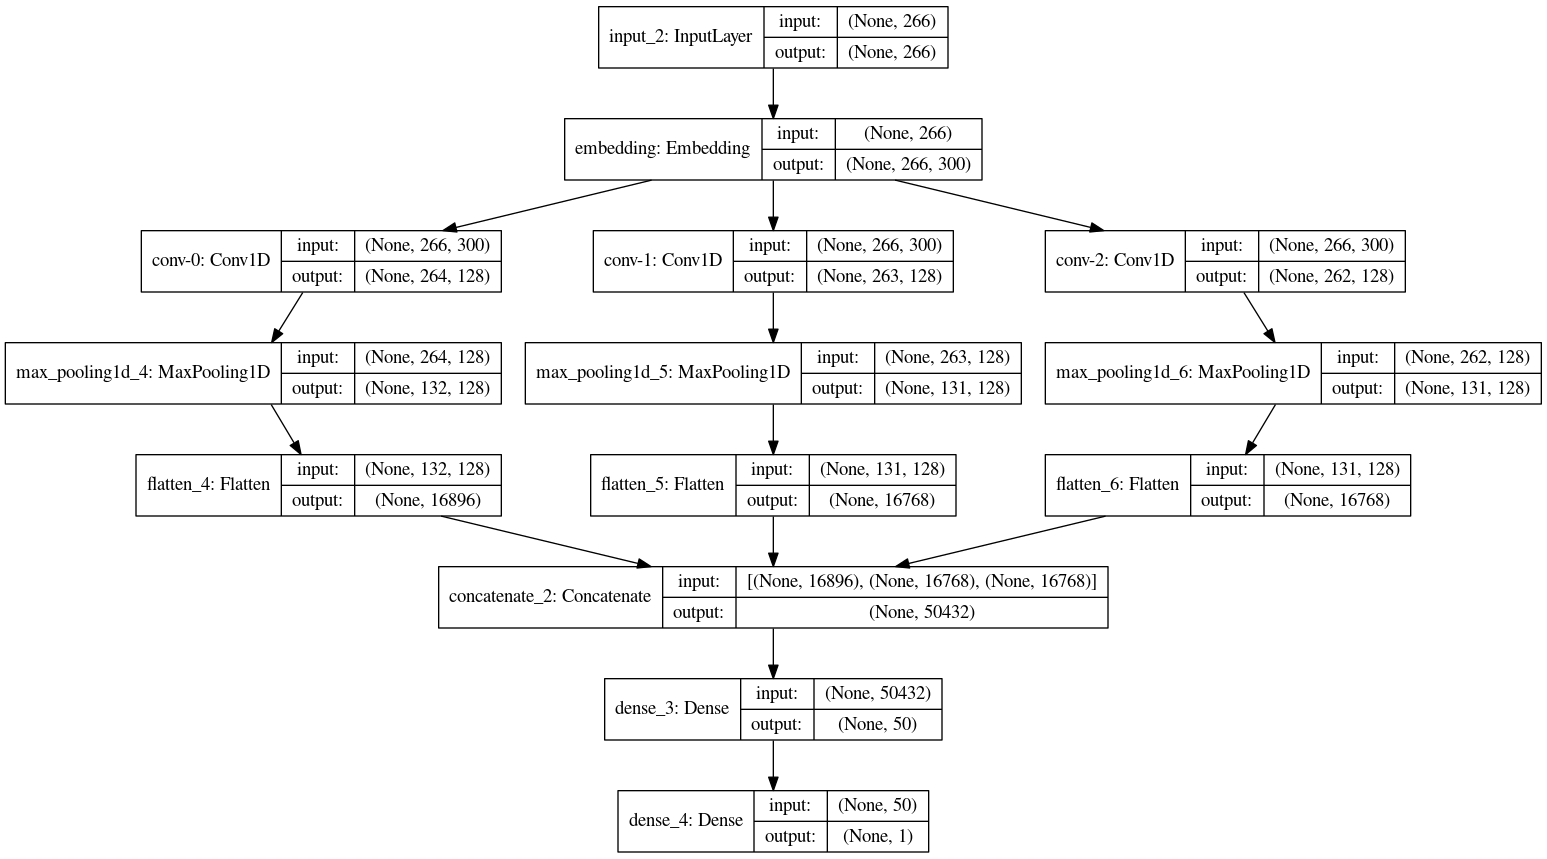

In [12]:
VOCAB_SIZE = len(word_index)+1
EMBED_SIZE = 300
NUM_FILTERS = 128
FILTER_SIZE = [3,4,5]
model = create_model(vocab_size=VOCAB_SIZE,
                     embedding_dim=EMBED_SIZE,
                     num_filters=NUM_FILTERS,
                     filter_size=FILTER_SIZE,
                     max_sequence_length=max_sequence_length)
model.summary()
plot_model(model,to_file="model.png",show_shapes=True)

**Train Model**

In [13]:
BATCH_SIZE = 128
NUM_EPOCHS = 5
#https://keras.io/api/models/model_training_apis/#fit-method
history = model.fit(x_train,
          y_train, 
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_split=0.2,
          shuffle=True)
history_dict = history.history
print(history_dict.keys())

Train on 6823 samples, validate on 1706 samples
Epoch 1/5
6823/6823 [==============================] - 6s 851us/step - loss: 0.7008 - accuracy: 0.5184 - val_loss: 0.6880 - val_accuracy: 0.5246
Epoch 2/5
6823/6823 [==============================] - 3s 418us/step - loss: 0.5607 - accuracy: 0.7218 - val_loss: 0.5118 - val_accuracy: 0.7485
Epoch 3/5
6823/6823 [==============================] - 3s 419us/step - loss: 0.2173 - accuracy: 0.9168 - val_loss: 0.5736 - val_accuracy: 0.7497
Epoch 4/5
6823/6823 [==============================] - 3s 420us/step - loss: 0.0695 - accuracy: 0.9814 - val_loss: 0.7539 - val_accuracy: 0.7392
Epoch 5/5
6823/6823 [==============================] - 3s 418us/step - loss: 0.0197 - accuracy: 0.9959 - val_loss: 0.9225 - val_accuracy: 0.7374
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


**Evaluate model**

In [14]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

2133/2133 [==============================] - 0s 196us/step
Testing Accuracy:  0.7515


**Visualize accuracy**

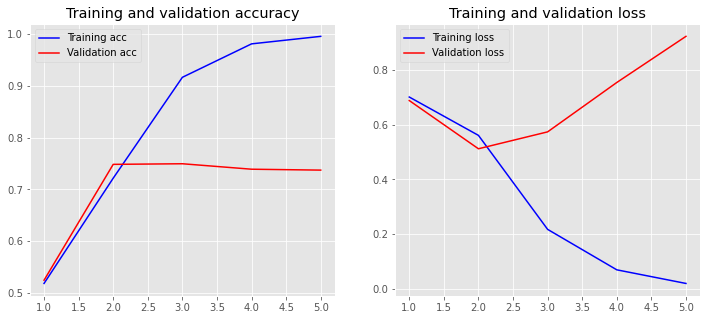

In [15]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

**Confusion matrix**

In [22]:
predicted_proba = model.predict(x_test)
y_pred = tf.greater(predicted_proba, .5).numpy()
y_pred

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [False]])

In [23]:
matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)
matrix

array([[836, 244],
       [286, 767]])

Text(33.0, 0.5, 'Actual')

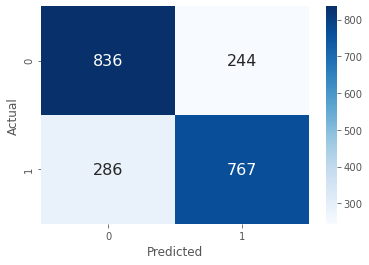

In [24]:
sns.heatmap(matrix, annot=True, annot_kws={"size": 16},cmap='Blues', fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [25]:
target_names = ['class 0', 'class 1']
print(classification_report(y_true=[np.argmax(x) for x in y_test],y_pred=y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      0.53      0.69      2133
     class 1       0.00      0.00      0.00         0

    accuracy                           0.53      2133
   macro avg       0.50      0.26      0.34      2133
weighted avg       1.00      0.53      0.69      2133

